In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from torch.utils.data import Subset
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:1


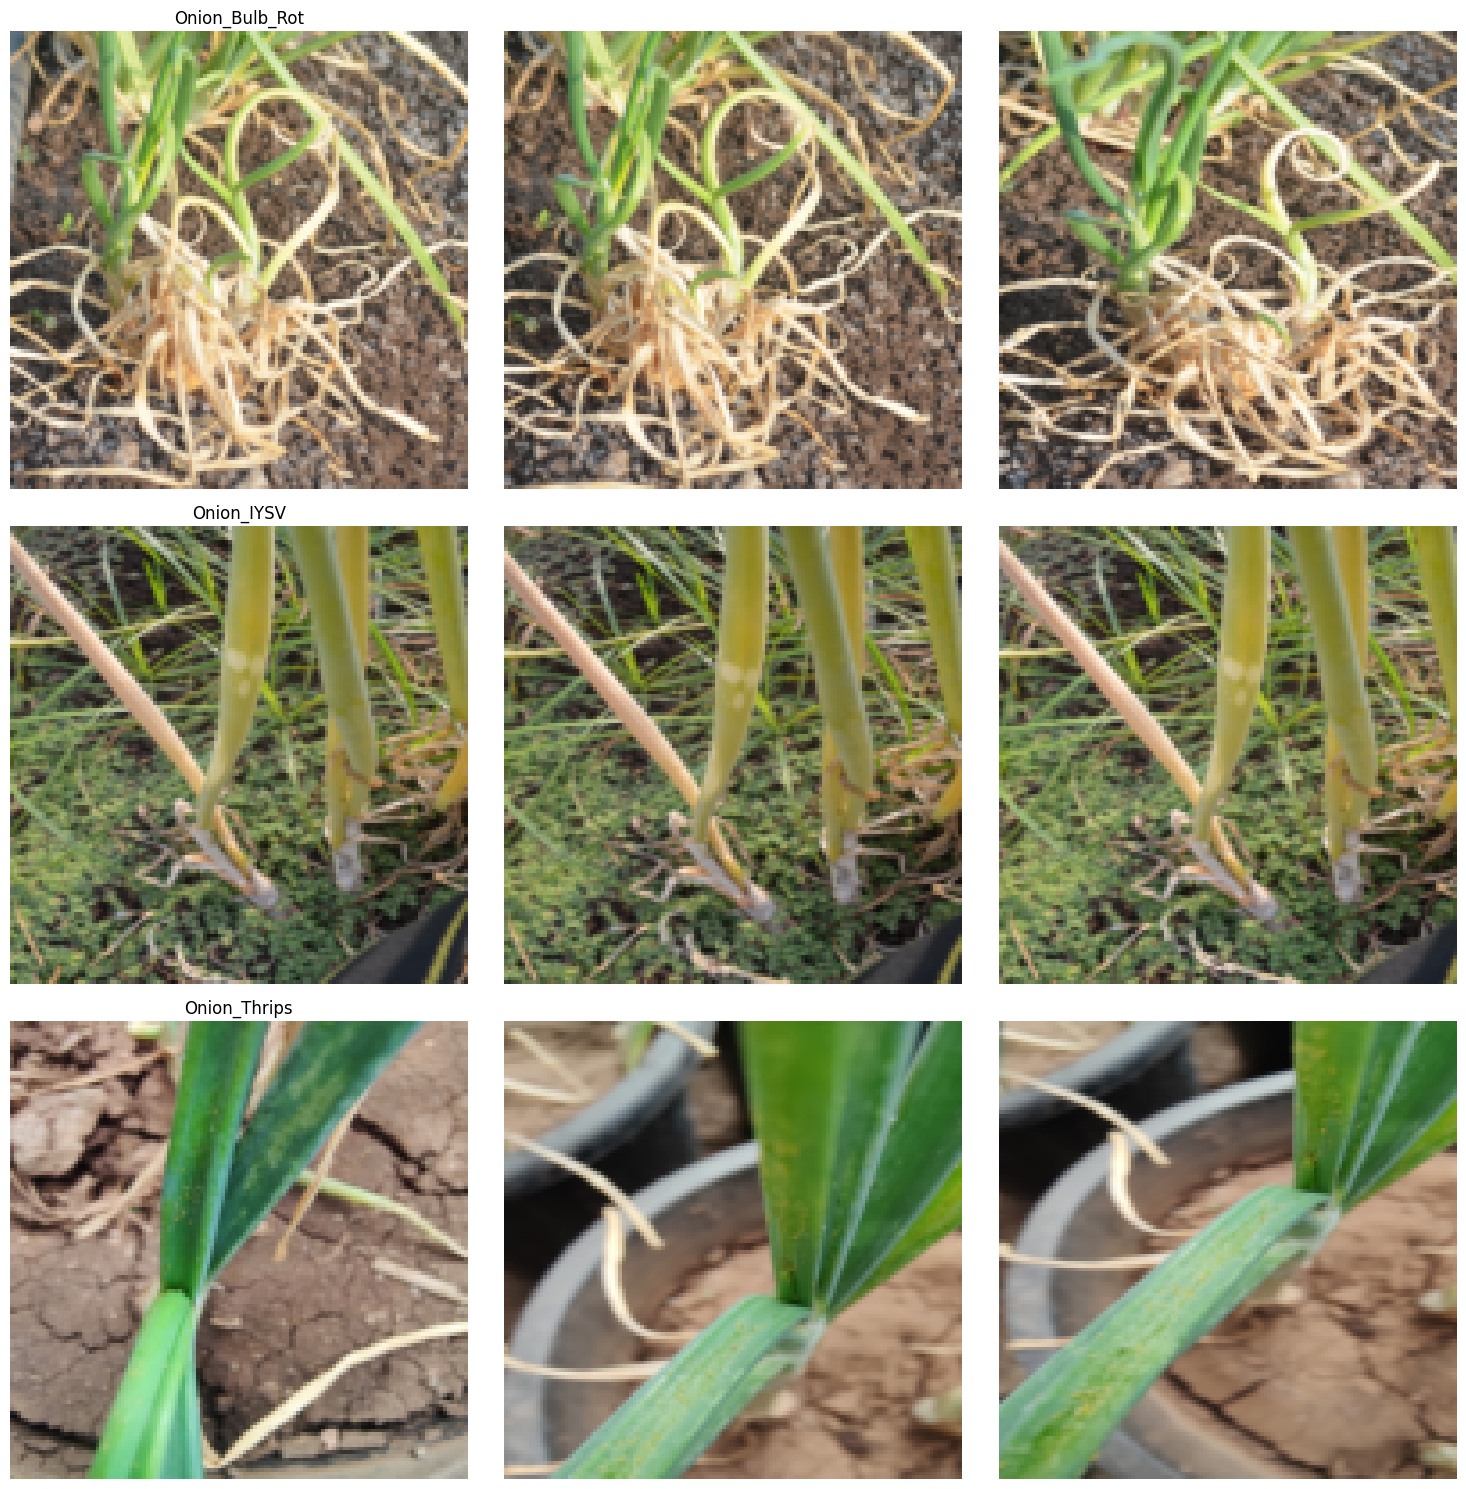

In [19]:
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import random

# Define the directory and transformations
data_dir = '/raid/ee-mariyam/maryam/ayush/TiH_Onion_data'
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to a fixed size
    transforms.ToTensor()  # Convert images to tensors
])

# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Preload a small number of images per class
def preload_samples(dataset, samples_per_class=3):
    class_indices = {i: [] for i in range(len(dataset.classes))}
    class_samples = {i: [] for i in range(len(dataset.classes))}

    # Collect indices of each class
    for idx, (img, label) in enumerate(dataset):
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)
            class_samples[label].append(img)
        if all(len(indices) >= samples_per_class for indices in class_indices.values()):
            break
    
    return class_samples

class_samples = preload_samples(dataset)

# Function to plot images
def plot_images_by_class(class_samples, samples_per_class=3):
    num_classes = len(class_samples)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 15))
    
    if num_classes == 1:
        axes = [axes]

    # Plot images
    for class_idx, (class_name, samples) in enumerate(zip(dataset.classes, class_samples.values())):
        for sample_idx, img in enumerate(samples):
            axes[class_idx][sample_idx].imshow(img.permute(1, 2, 0))  # Convert from CHW to HWC
            axes[class_idx][sample_idx].axis('off')
            if sample_idx == 0:
                axes[class_idx][sample_idx].set_title(class_name)

    plt.tight_layout()
    plt.show()

# Plot the images
plot_images_by_class(class_samples)


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define data transformations (you can customize these as needed)
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the images to a common size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])
# Replace 'data_dir' with the path to your dataset folder
data_dir = '/raid/ee-mariyam/maryam/ayush/TiH_Onion_data'

# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)
# Define the percentage split for train, validation, and test
train_percentage = 0.50
val_percentage = 0.25
test_percentage = 0.25

# Calculate the sizes of each split
num_data = len(dataset)
num_train = int(train_percentage * num_data)
num_val = int(val_percentage * num_data)
num_test = num_data - num_train - num_val

# Use random_split to split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test], generator=torch.Generator().manual_seed(42))
# Define batch size for data loaders
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)


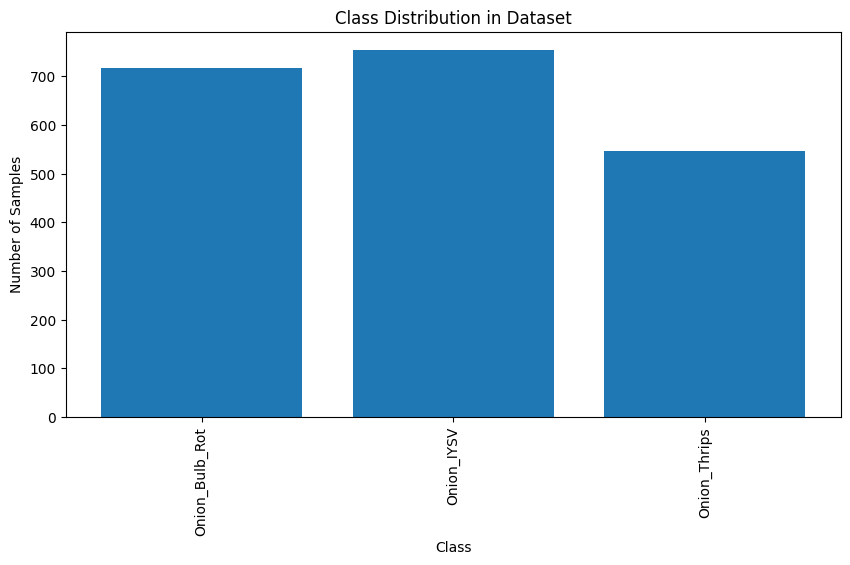

In [17]:
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import numpy as np

# Assuming data_dir and transform are already defined
# dataset = ImageFolder(root=data_dir, transform=transform)

# Extract class names and the number of samples per class
class_names = dataset.classes
class_counts = [0] * len(class_names)

for _, label in dataset.samples:
    class_counts[label] += 1

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Onion Dataset')
plt.xticks(rotation=90)  # Rotate class names for better readability if they are long
plt.show()


In [3]:
import timm
import torch
from timm.models import create_model

# Define model (choose appropriate ConvNeXt variant)
model = create_model('convnext_base', pretrained=True)  # Adjust variant (e.g., 'convnext_small', 'convnext_base')

# Freeze pre-trained layers for fine-tuning (optional)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final classifier layer for the number of PlantVillage classes
num_classes = 10  # Get number of classes from dataset
model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)  # Replace final layer

# Unfreeze the last few layers for fine-tuning (optional)
for param in model.head.parameters():
    param.requires_grad = True  # Unfreeze final layers

/raid/ee-mariyam/maryam/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Fine-tune the model
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
training_start_time = time.time()
training_loss = []
validation_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # logits = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    training_loss.append(train_loss)
    train_accuracy = 100 * correct_predictions / total_predictions

    # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%")
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_predictions = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total_predictions += val_labels.size(0)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    validation_loss.append(val_loss)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Epoch 1/10, Train Loss: 1.4202, Train Accuracy: 54.66%, Val Loss: 0.9163, Val Accuracy: 81.15%
Epoch 2/10, Train Loss: 0.7137, Train Accuracy: 86.90%, Val Loss: 0.5914, Val Accuracy: 88.69%
Epoch 3/10, Train Loss: 0.4900, Train Accuracy: 92.46%, Val Loss: 0.4448, Val Accuracy: 92.46%
Epoch 4/10, Train Loss: 0.3786, Train Accuracy: 94.35%, Val Loss: 0.3623, Val Accuracy: 94.44%
Epoch 5/10, Train Loss: 0.3077, Train Accuracy: 95.83%, Val Loss: 0.3071, Val Accuracy: 94.64%
Epoch 6/10, Train Loss: 0.2627, Train Accuracy: 96.33%, Val Loss: 0.2698, Val Accuracy: 96.03%
Epoch 7/10, Train Loss: 0.2318, Train Accuracy: 96.92%, Val Loss: 0.2402, Val Accuracy: 96.03%
Epoch 8/10, Train Loss: 0.2037, Train Accuracy: 97.12%, Val Loss: 0.2178, Val Accuracy: 95.83%
Epoch 9/10, Train Loss: 0.1827, Train Accuracy: 97.52%, Val Loss: 0.1998, Val Accuracy: 96.23%
Epoch 10/10, Train Loss: 0.1646, Train Accuracy: 97.92%, Val Loss: 0.1843, Val Accuracy: 96.23%
Training finished, took 488.18s


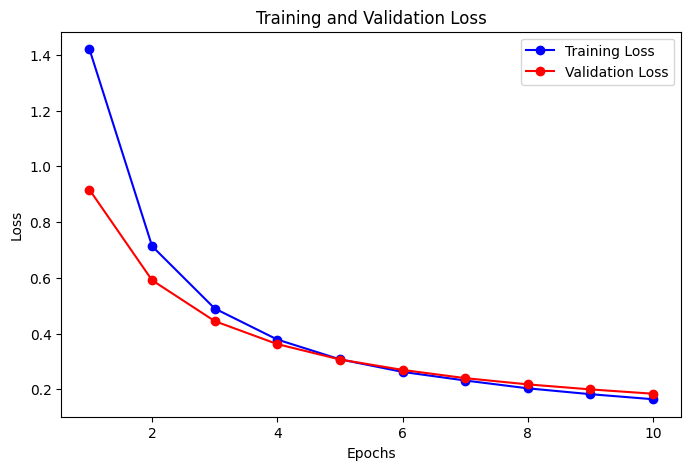

In [5]:
import matplotlib.pyplot as plt

# Define the x-axis (epochs)
epochs = range(1, len(training_loss) + 1)

# Create a figure and plot the training loss and validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [6]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = 100 * correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.42%


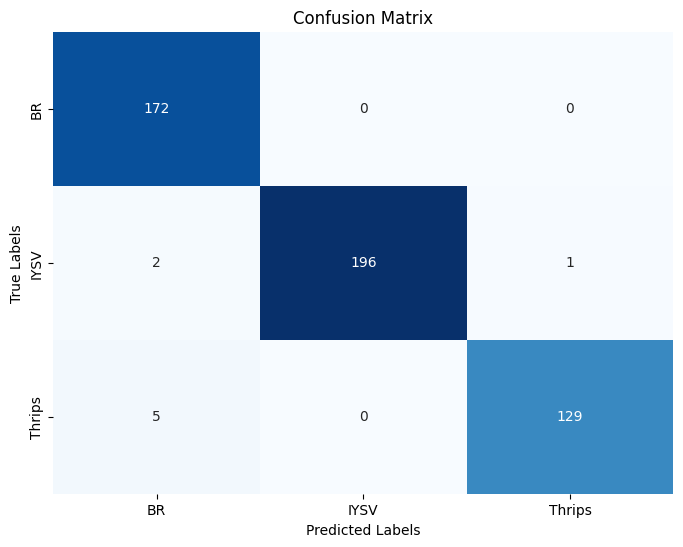

In [8]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Replace 'dataloader' with your data loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Assuming a classification task with class indices
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix as a heatmap
class_names = ["BR", "IYSV", "Thrips"] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
